In [3]:
%run './model/multi_corpus.py'
%run './model/ergm_functions.py'
%run './constants.py'

import networkx as nx
import polars as pl
from netgraph import Graph
from IPython.display import clear_output
import itertools

In [4]:
corpora = co_occurence_graphs(n_edges=100)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 57 nodes and 100 edges
Geometry Graph with 61 nodes and 100 edges
Geophysics Graph with 63 nodes and 100 edges
Economics Graph with 50 nodes and 100 edges
Language & Linguistics Graph with 58 nodes and 100 edges
Probability & Statistics Graph with 58 nodes and 100 edges
Material Engineering Graph with 49 nodes and 100 edges
Artificial Intelligence Graph with 49 nodes and 100 edges
Sociology Graph with 76 nodes and 100 edges
International Business Graph with 51 nodes and 100 edges
Political Science Graph with 56 nodes and 100 edges
Genetics & Genomics Graph with 71 nodes and 100 edges
Immunology Graph with 92 nodes and 100 edges
Human Resources & Organizations Graph with 66 nodes and 100 edges
Ethnic & Cultural Studies Graph with 52 nodes and 100 edges
Neurology Graph with 46 nodes and 100 edges


In [5]:
dfs_temporal_path = './dfs_temporal'

dfs_temporal = defaultdict(dict)

for field_name in os.listdir(dfs_temporal_path):

    dfs_year_path = os.path.join(dfs_temporal_path, field_name)
    for df_year_path in os.listdir(dfs_year_path):

        year = df_year_path.split('.')[0]
        df_year = pl.read_parquet(os.path.join(dfs_temporal_path, field_name, df_year_path))

        dfs_temporal[field_name][int(year)] = df_year

In [8]:
sorted(dfs_temporal['Economics'].keys())

[1988,
 1989,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

In [101]:
def jaccard(c1, c2):
    intersection = set(c1).intersection(set(c2))
    union = set(c1).union(set(c2))
    jaccard = len(intersection) / len(union)
    return jaccard

def is_same(c1, c2, threshold=0.7):
    similarity = jaccard(c1, c2)
    similar_enough = similarity >= threshold
    is_subset = c1.issubset(c2) or c2.issubset(c1)
    # contains_gt = len(set(list(c1)[:3]).intersection(set(list(c2)[:3]))) >= 1
    return similar_enough or is_subset # or contains_gt

def get_community_core(c, coreness, threshold=1):
    core_community = dict(filter(lambda tup: tup[0] in c, coreness.items()))
    core_community = dict(filter(lambda tup: tup[1] >= max(core_community.values())-threshold, core_community.items()))
    core_community = dict(sorted(core_community.items(), key=lambda tup: tup[1]))
    core_community = frozenset(core_community.keys())
    return core_community

def get_community_importance(c, G):
    return sum([d['weight'] for (_, _, d) in G.subgraph(c).edges(data=True)])

def prune_edges(G):
    G_pruned = G.copy()
    for node in G.nodes():
        predecessors = list(G.predecessors(node))
        if predecessors:
            predecessors.sort()
            for pred in predecessors[:-1]:
                if G_pruned.has_edge(pred, node):
                    G_pruned.remove_edge(pred, node)
    return G_pruned

In [102]:
field_name = 'Sociology'

In [103]:
communities = []

sorted_dfs = sorted(dfs_temporal[field_name].items(), key=lambda t: t[0])
for year, df in sorted_dfs:
    G = nx.Graph()
    G.add_weighted_edges_from(df.rows())

    coreness = nx.core_number(G)
    for community in nx.community.louvain_communities(G):
        community = get_community_core(community, coreness)
        communities.append((year, community))

In [104]:
communities

[(1992,
  frozenset({'child',
             'employment',
             'enrollment',
             'industry',
             'school',
             'white'})),
 (1992, frozenset({'income', 'inequality', 'national', 'simpson'})),
 (1992,
  frozenset({'black',
             'competition',
             'county',
             'lynching',
             'populist',
             'rate'})),
 (1992, frozenset({'social', 'state', 'theory', 'transformation'})),
 (1992,
  frozenset({'failure',
             'hmo',
             'organization',
             'relationship',
             'size',
             'type'})),
 (1992, frozenset({'dismissal', 'job'})),
 (1992, frozenset({'mesomobilization', 'mobilization'})),
 (1993,
  frozenset({'child',
             'employment',
             'enrollment',
             'industry',
             'opportunity',
             'school'})),
 (1993,
  frozenset({'exchange',
             'investment',
             'power',
             'process',
             'state',
    

In [105]:
years = sorted(set([year for year, _ in communities]))
max_year = max(years)

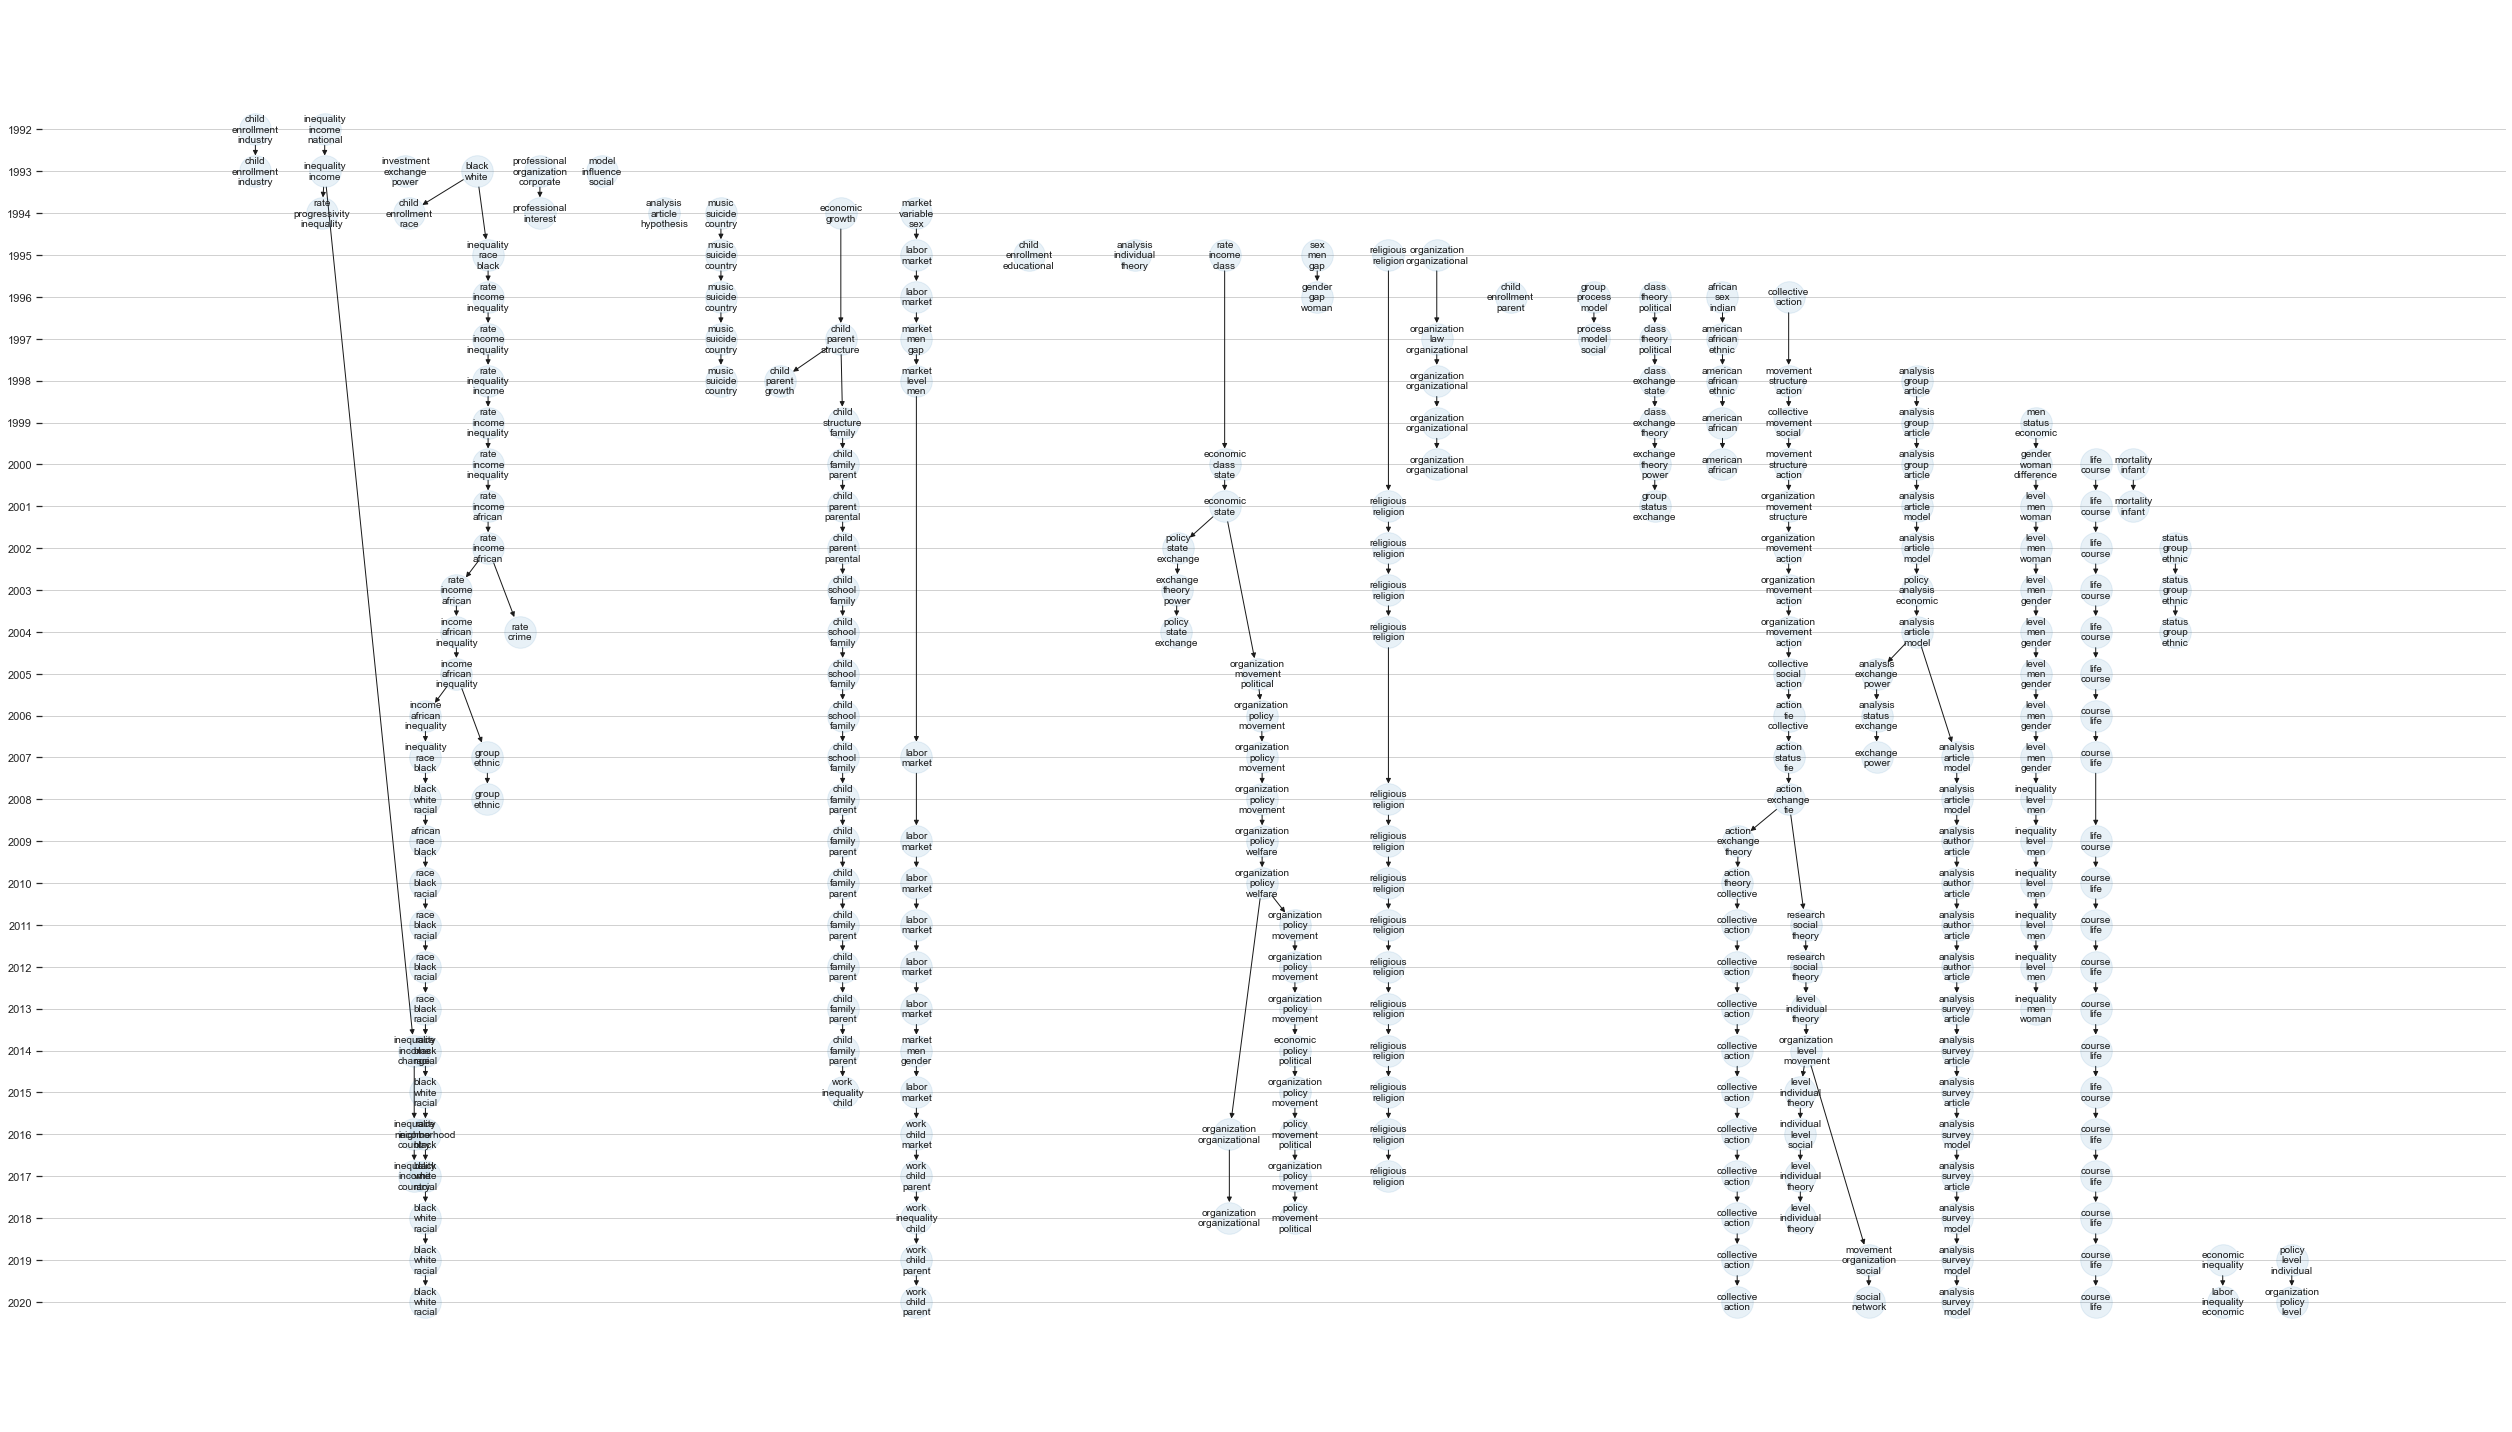

In [106]:
G = nx.DiGraph()
for (year_i, community_i), (year_j, community_j) in itertools.combinations(communities, 2):
    if is_same(community_i, community_j):
        G.add_edge((year_i, community_i), (year_j, community_j))

G = prune_edges(G)

node_labels = {(year, terms): '\n'.join(list(terms)[:3]) for year, terms in G.nodes()}

pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

for (year, node), coord in pos.items():
    pos[(year, node)] = (coord[0], max_year-year)

fig, ax = plt.subplots(1, figsize=(35, 20))

nx.draw_networkx_nodes(
    G, 
    pos,
    # nodelist=tree.nodes,
    node_size=1000,
    # node_size=node_size,
    # node_color=node_colors,
    node_shape='o',
    alpha=0.1,
    # alpha=node_alphas,
    # cmap=plt.cm.Blues,
    ax=ax,
)

nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=node_labels, font_size=10)

nx.draw_networkx_edges(
    G, 
    pos,
    # edgelist=tree.edges,
    # width=edge_width,
    # style='solid',
    # alpha=edge_alphas,
    # arrowsize=10,
    # arrows=False,
    ax=ax,
    # edge_color=edge_colors,
    # nodelist=tree.nodes,
    node_size=1000,
    # node_size=node_size,
    node_shape='o',
    connectionstyle='arc3',
)

ax.set_facecolor('white')

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)

_, ys = zip(*pos.values())
ax.set_yticks(sorted(set(ys)))
ax.set_yticklabels(sorted(years, reverse=True))
ax.grid(axis='y', linestyle='-', color='k', alpha=0.2)


for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)

plt.tight_layout()
plt.show()

In [1]:
# Field     Community       Year        SVD         Category (Hard / Soft)

In [5]:
def jaccard(c1, c2):
    intersection = set(c1).intersection(set(c2))
    union = set(c1).union(set(c2))
    jaccard = len(intersection) / len(union)
    return jaccard

def is_same(c1, c2, threshold=0.7):
    similarity = jaccard(c1, c2)
    similar_enough = similarity >= threshold
    is_subset = c1.issubset(c2) or c2.issubset(c1)
    # contains_gt = len(set(list(c1)[:3]).intersection(set(list(c2)[:3]))) >= 1
    return similar_enough or is_subset # or contains_gt

In [40]:
df_field = dfs_temporal['Sociology']

all_communities = set()
for year, df in df_field.items():
    G = nx.Graph()
    G.add_weighted_edges_from(df.rows())
    communities = nx.community.louvain_communities(G)
    all_communities = all_communities | set(map(frozenset, communities))

G = nx.Graph()
for community_1, community_2 in itertools.combinations(all_communities, 2):
    if is_same(community_1, community_2, threshold=1):
        G.add_edge(community_1, community_2)

community_map = dict()
for i, component in enumerate(nx.connected_components(G)):
    for communitiy in component:
        community_map[communitiy] = i

# df_community = pl.DataFrame({
#     'Community': list(community_map.keys()),
#     'Id': list(community_map.values()),
# })

# df_community

In [42]:
len(all_communities)

149

In [20]:
field_type = {
    'Gender Studies': 0,
    'Economics': 0,
    'Language & Linguistics': 0,
    'Sociology': 0,
    'International Business': 0,
    'Political Science': 0,
    'Human Resources & Organizations': 0,
    'Ethnic & Cultural Studies': 0,
    'Geometry': 1,
    'Geophysics': 1,
    'Probability & Statistics': 1,
    'Material Engineering': 1,
    'Artificial Intelligence': 1,
    'Genetics & Genomics': 1,
    'Immunology': 1,
    'Neurology': 1,
}

In [89]:
seed = 100

df_final = pl.DataFrame()
for field_name, year_df in dfs_temporal.items():

    all_communities = set()
    for year, df in year_df.items():
        G = nx.Graph()
        G.add_weighted_edges_from(df.rows())
        communities = nx.community.louvain_communities(G, seed=seed)
        all_communities = all_communities | set(map(frozenset, communities))

    all_communities_ids = dict(zip(all_communities, range(len(all_communities))))
    community_ids = [all_communities_ids[c] for c in all_communities]
    all_communities = [list(c) for c in all_communities]

    for year, df in year_df.items():
        G = nx.Graph()
        G.add_weighted_edges_from(df.rows())
        communities = nx.community.louvain_communities(G, seed=seed)

        G_community = nx.Graph()
        for community_1, community_2 in itertools.product(communities, communities):

            boundary_edges = nx.edge_boundary(G, community_1, community_2)
            sum_weighted_boundary_edges = sum(G[u][v]['weight'] for u, v in boundary_edges)

            u = frozenset(community_1)
            v = frozenset(community_2)
            if u not in G_community:
                G_community.add_node(u)
            if v not in G_community:
                G_community.add_node(v)
            if sum_weighted_boundary_edges:
                G_community.add_edge(u, v, weight=sum_weighted_boundary_edges)

        M = nx.to_numpy_array(G_community)

        U, S, Vt = np.linalg.svd(M)
        
        # Use the first left singular vector to identify core/periphery
        u1 = U[:, 0]
        u1 = np.abs(u1)

        df_svd = pl.DataFrame({
            'CommunityId': [all_communities_ids[c] for c in G_community.nodes],
            'Svd': u1,
        })

        df_type = pl.DataFrame({
            'Field': list(field_type.keys()),
            'Type': list(field_type.values()),
        })

        df = pl.DataFrame({
            'Field': field_name,
            'Community': all_communities,
            'CommunityId': community_ids,
            'Year': year,
        })

        df = df.join(df_svd, on='CommunityId', how='left')
        df = df.join(df_type, on='Field', how='left')

        df_final = pl.concat([df_final, df], rechunk=True)

df_final.sort('Field', 'CommunityId', 'Year')

shape: (65_220, 6)
┌─────────────────────────┬───────────────────────────────────┬─────────────┬──────┬──────┬──────┐
│ Field                   ┆ Community                         ┆ CommunityId ┆ Year ┆ Svd  ┆ Type │
│ ---                     ┆ ---                               ┆ ---         ┆ ---  ┆ ---  ┆ ---  │
│ str                     ┆ list[str]                         ┆ i64         ┆ i64  ┆ f64  ┆ i64  │
╞═════════════════════════╪═══════════════════════════════════╪═════════════╪══════╪══════╪══════╡
│ Artificial Intelligence ┆ ["using", "object", … "based"]    ┆ 0           ┆ 1991 ┆ null ┆ 1    │
│ Artificial Intelligence ┆ ["using", "object", … "based"]    ┆ 0           ┆ 1992 ┆ null ┆ 1    │
│ Artificial Intelligence ┆ ["using", "object", … "based"]    ┆ 0           ┆ 1993 ┆ null ┆ 1    │
│ Artificial Intelligence ┆ ["using", "object", … "based"]    ┆ 0           ┆ 1994 ┆ null ┆ 1    │
│ …                       ┆ …                                 ┆ …           ┆ …    ┆ …    ┆ …    │
│ Sociology               ┆ ["opportunity", "race", … "schoo… ┆ 147         ┆ 2017 ┆ null ┆ 0    │
│ Sociology               ┆ ["opportunity", "race", … "schoo… ┆ 147         ┆ 2018 ┆ null ┆ 0    │
│ Sociology               ┆ ["opportunity", "race", … "schoo… ┆ 147         ┆ 2019 ┆ null ┆ 0    │
│ Sociology               ┆ ["opportunity", "race", … "schoo… ┆ 147         ┆ 2020 ┆ null ┆ 0    │
└─────────────────────────┴───────────────────────────────────┴─────────────┴──────┴──────┴──────┘

In [1]:
df_final

NameError: name 'df_final' is not defined

In [ ]:
# Fixed effects 

# Dummy variable for each community

# Hausman test

# SVD ~ CommunityID (Dummy), Type, Year, Type_Year (Interaction)



In [98]:
df_final.filter(pl.col('Field').eq('Sociology') & pl.col('Svd').is_not_null())

shape: (269, 6)
┌───────────┬───────────────────────────────────┬─────────────┬──────┬──────────┬──────┐
│ Field     ┆ Community                         ┆ CommunityId ┆ Year ┆ Svd      ┆ Type │
│ ---       ┆ ---                               ┆ ---         ┆ ---  ┆ ---      ┆ ---  │
│ str       ┆ list[str]                         ┆ i64         ┆ i64  ┆ f64      ┆ i64  │
╞═══════════╪═══════════════════════════════════╪═════════════╪══════╪══════════╪══════╡
│ Sociology ┆ ["child", "school", … "family"]   ┆ 16          ┆ 1999 ┆ 0.116589 ┆ 0    │
│ Sociology ┆ ["rate", "inequality", … "area"]  ┆ 36          ┆ 1999 ┆ 0.083601 ┆ 0    │
│ Sociology ┆ ["organization", "organizational… ┆ 50          ┆ 1999 ┆ 0.024983 ┆ 0    │
│ Sociology ┆ ["analysis", "group", … "data"]   ┆ 67          ┆ 1999 ┆ 0.365952 ┆ 0    │
│ …         ┆ …                                 ┆ …           ┆ …    ┆ …        ┆ …    │
│ Sociology ┆ ["collective", "action"]          ┆ 118         ┆ 2019 ┆ 0.0      ┆ 0    │
│ Sociology ┆ ["black", "white", … "race"]      ┆ 124         ┆ 2019 ┆ 0.0      ┆ 0    │
│ Sociology ┆ ["course", "life"]                ┆ 132         ┆ 2019 ┆ 0.018285 ┆ 0    │
│ Sociology ┆ ["policy", "organization", … "st… ┆ 139         ┆ 2019 ┆ 0.2016   ┆ 0    │
└───────────┴───────────────────────────────────┴─────────────┴──────┴──────────┴──────┘

In [95]:
df_final.select(pl.all().exclude('Community')).write_csv('./data.csv')

In [ ]:
# Mixed effect 
# If inconclusive 
# Time series model

# Average shortest path within community

First left singular vector from the Singular Value Decomposition

1. **Magnitude and Direction**:

The values in $u_1$ can be both positive and negative. Their magnitude (absolute value) indicates the strength or prominence of a node's position in the network, while the sign (positive or negative) can sometimes indicate different roles or groupings within the network.

In [22]:
df_final.sort(['Field', 'Year'])

shape: (2_831, 5)
┌─────────────────────────┬──────┬───────────────────────────────────┬──────────┬──────┐
│ Field                   ┆ Year ┆ Community                         ┆ Svd      ┆ Type │
│ ---                     ┆ ---  ┆ ---                               ┆ ---      ┆ ---  │
│ str                     ┆ i64  ┆ list[str]                         ┆ f64      ┆ i64  │
╞═════════════════════════╪══════╪═══════════════════════════════════╪══════════╪══════╡
│ Artificial Intelligence ┆ 1991 ┆ ["grouping", "required", … "inde… ┆ 0.544386 ┆ 1    │
│ Artificial Intelligence ┆ 1991 ┆ ["based", "search", … "vision"]   ┆ 0.595759 ┆ 1    │
│ Artificial Intelligence ┆ 1991 ┆ ["lambertian", "using", … "brigh… ┆ 0.590521 ┆ 1    │
│ Artificial Intelligence ┆ 1992 ┆ ["work", "used", … "localization… ┆ 0.389327 ┆ 1    │
│ …                       ┆ …    ┆ …                                 ┆ …        ┆ …    │
│ Sociology               ┆ 2020 ┆ ["work", "child", … "family"]     ┆ 0.136201 ┆ 0    │
│ Sociology               ┆ 2020 ┆ ["policy", "organization", … "st… ┆ 0.199685 ┆ 0    │
│ Sociology               ┆ 2020 ┆ ["life", "course"]                ┆ 0.018352 ┆ 0    │
│ Sociology               ┆ 2020 ┆ ["collective", "action"]          ┆ 0.0      ┆ 0    │
└─────────────────────────┴──────┴───────────────────────────────────┴──────────┴──────┘

In [34]:
df_final['Field'].unique().to_list()

['Probability & Statistics',
 'Geophysics',
 'Genetics & Genomics',
 'Sociology',
 'Material Engineering',
 'Political Science',
 'Geometry',
 'Neurology',
 'Artificial Intelligence',
 'Immunology',
 'International Business',
 'Language & Linguistics',
 'Ethnic & Cultural Studies',
 'Human Resources & Organizations',
 'Economics',
 'Gender Studies']

# Lineages

In [37]:
df_field = dfs_temporal['Gender Studies']

all_communities = set()
for year, df in df_field.items():
    G = nx.Graph()
    G.add_weighted_edges_from(df.rows())
    communities = nx.community.louvain_communities(G)
    all_communities = all_communities | set(map(frozenset, communities))

G = nx.Graph()
for community_1, community_2 in itertools.combinations(all_communities, 2):
    if community_1.issubset(community_2):
        G.add_edge(community_1, community_2)

community_map = dict()
for component in nx.connected_components(G):
    lineage = set.union(*map(set, component))
    print(lineage)

{'occupation', 'target', 'men', 'group', 'female', 'male', 'participant', 'research', 'two', 'reaction', 'related', 'predicted', 'african', 'clustering', 'validity', 'toward', 'multiple', 'esteem', 'traditional', 'adolescent', 'sex', 'sexual', 'recall', 'individual', 'attitude', 'interaction', 'self', 'experience', 'level', 'measure', 'sample', 'perception', 'college', 'role', 'body', 'caucasian', 'predominantly', 'american', 'difference', 'family', 'career', 'behavior', 'sexism', 'conflict', 'relationship', 'gender', 'result', 'work', 'finding', 'medium', 'student', 'associated', 'woman', 'harassment', 'coercion', 'mras', 'feminist', 'would', 'masculinity', 'parent', 'gay', 'status', 'score', 'subject'}
{'feminine', 'target', 'typed', 'friendship', 'experiment', 'masculine', 'girl', 'boy', 'child', 'behavior', 'rating', 'sex', 'exclusively'}
{'self', 'experience', 'men', 'perception', 'ideal', 'college', 'dissatisfaction', 'medium', 'participant', 'body', 'esteem', 'woman', 'differenc

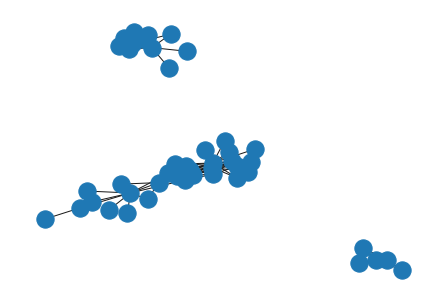

In [38]:
nx.draw(G)

In [ ]:
# Sum of weights of edges in and to communities over time

In [32]:
community_1 = frozenset({'a', 'b'})
community_2 = frozenset({'b', 'a'})

community_1.issubset(community_2)

True

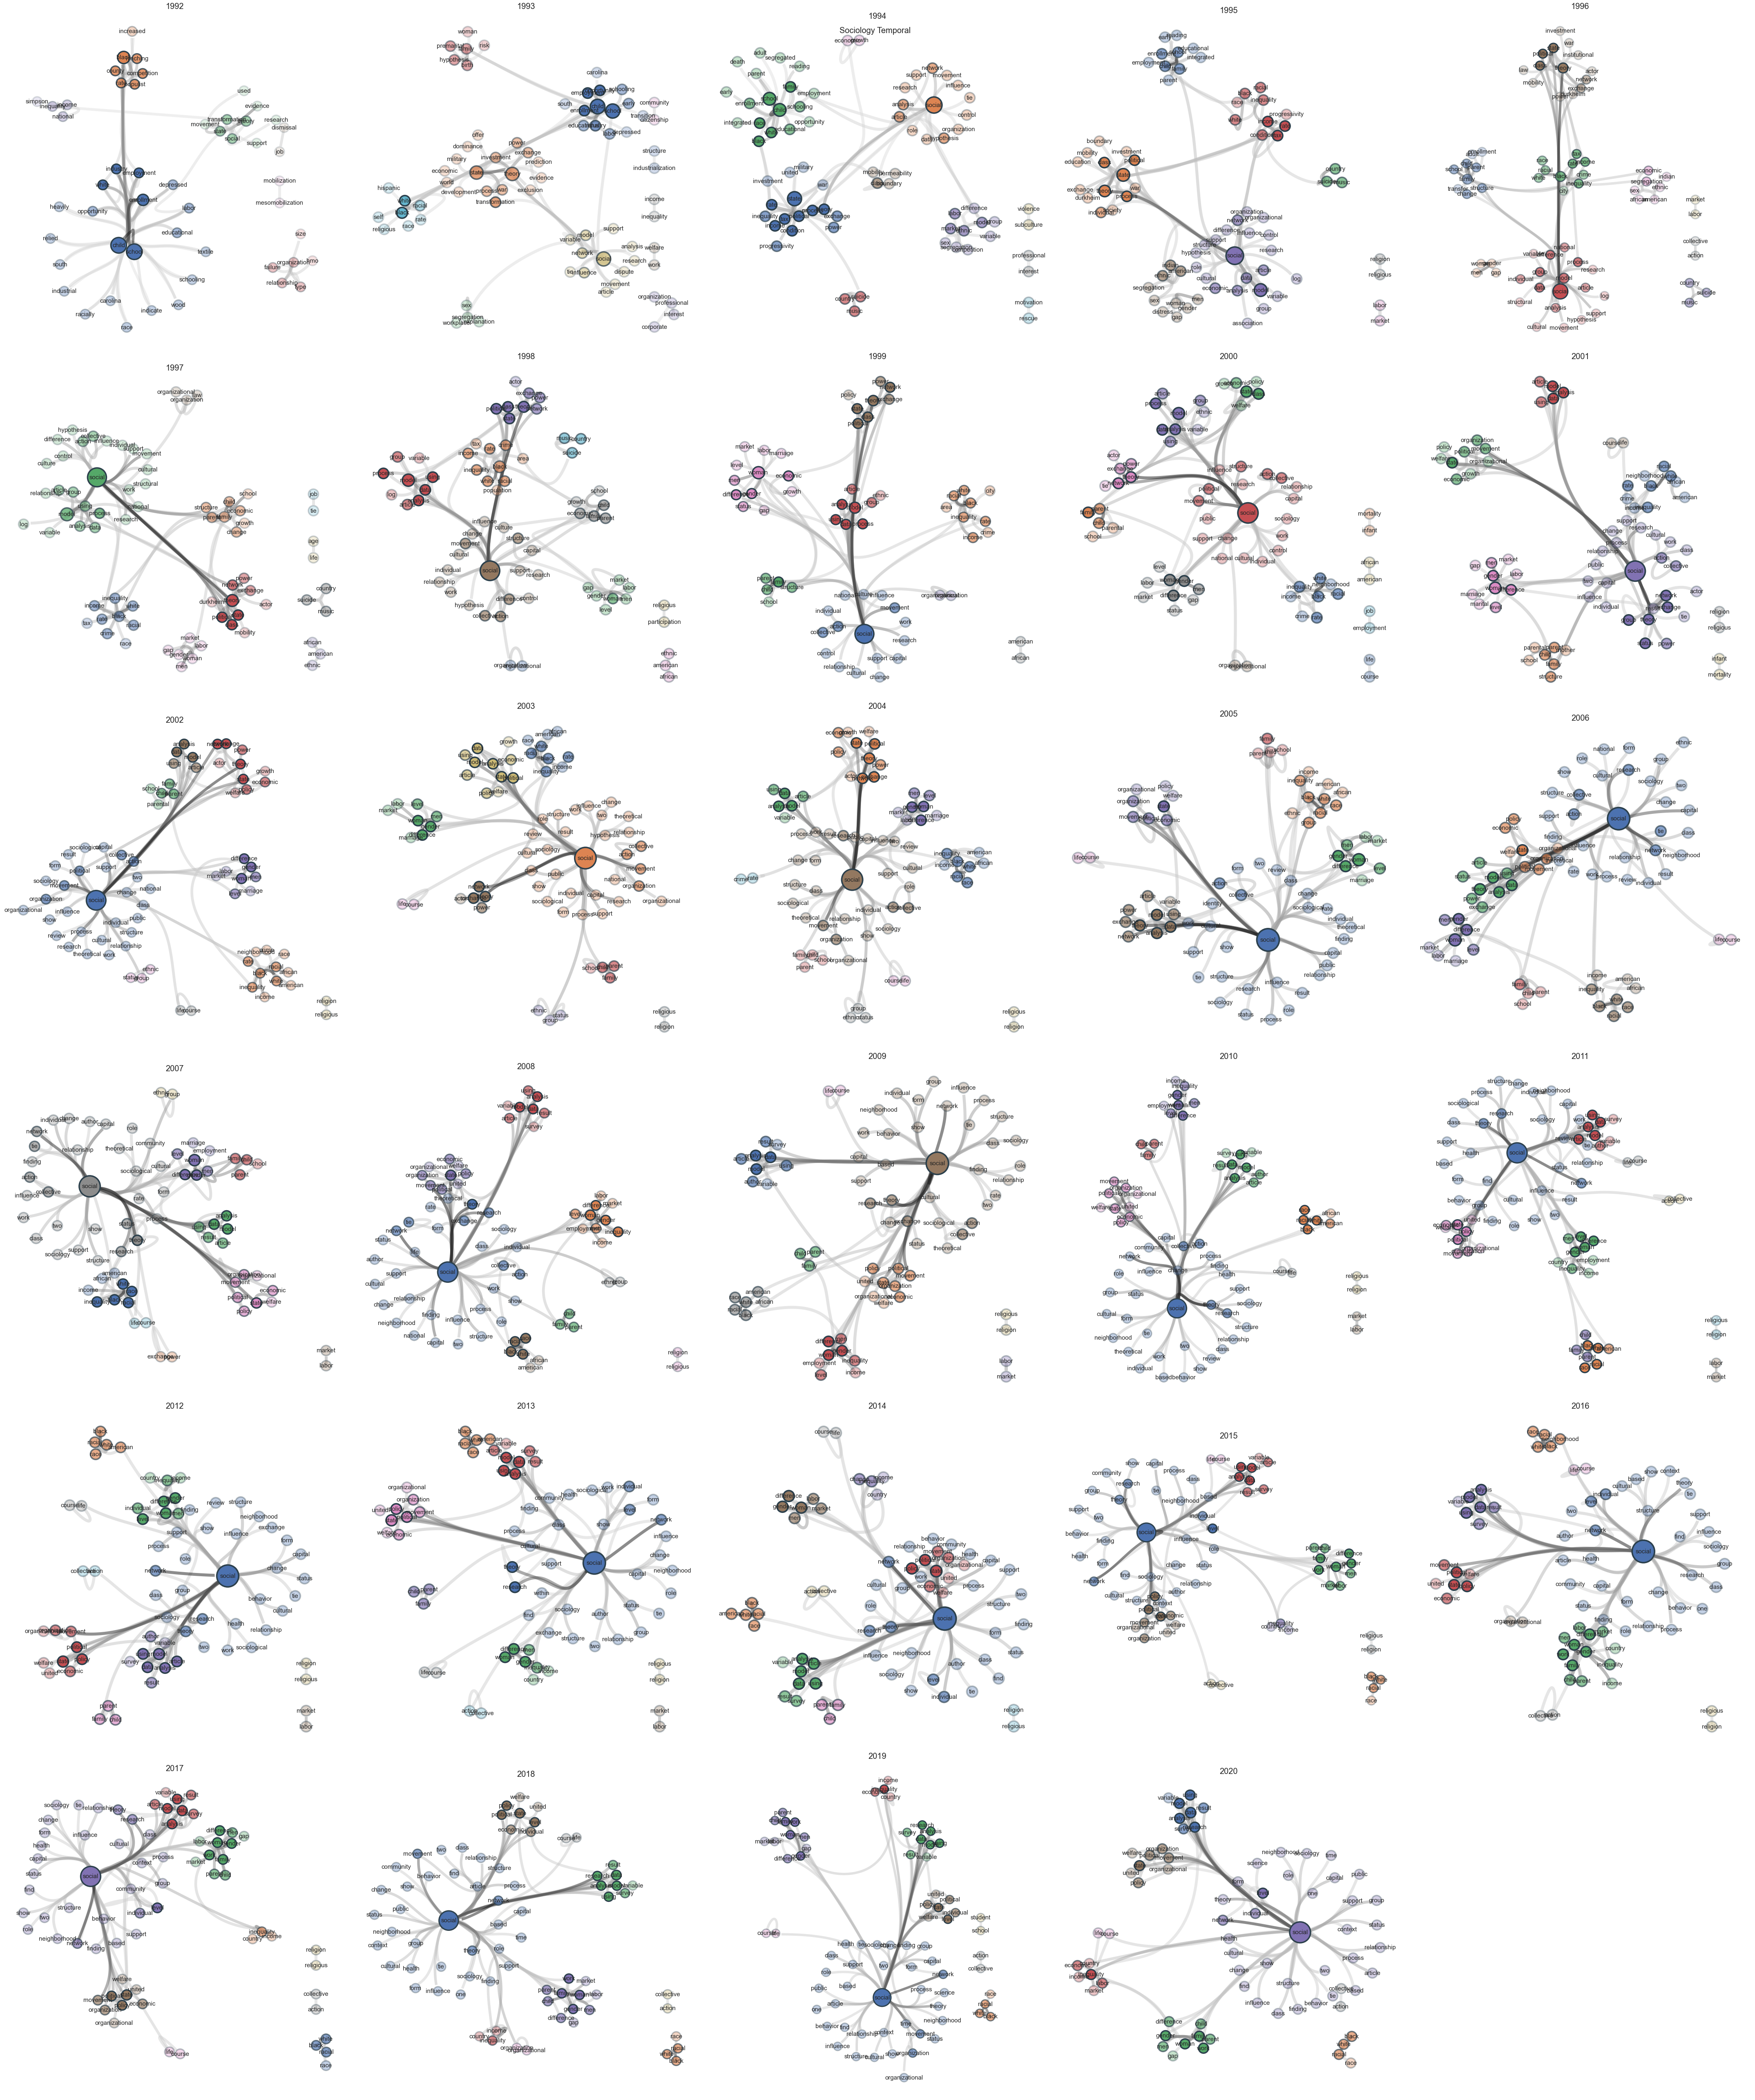

In [10]:
field_name = 'Sociology'
dfs = dfs_temporal[field_name]

num_years = len(dfs)
rows = int(np.ceil(np.sqrt(num_years)))
cols = int(np.ceil(num_years / rows))

fig, axes = plt.subplots(rows, cols, figsize=(12 * cols, 12 * rows))

if rows > 1 and cols > 1:
    axes = axes.ravel()
else:
    axes = [axes]

for idx, (year, df) in enumerate(sorted(dfs.items(), key=lambda tup: tup[0])):

    print(year), clear_output(wait=True)

    G = nx.Graph()
    G.add_weighted_edges_from(df.rows())

    communities = nx_comm.louvain_communities(G)
    num_comms = len(communities)
    communities = {node: i for i, comm in enumerate(communities) for node in comm}

    node_size = dict(nx.degree(G))
    node_size = {node: max(2, np.log(size)) for node, size in node_size.items()}

    comm_color = sns.color_palette(n_colors=num_comms)
    node_color = {node: comm_color[i] for node, i in communities.items()}

    node_alpha = nx.core_number(G)
    max_core = max(node_alpha.values())
    node_alpha = {n: core / max_core for n, core in node_alpha.items()}

    node_labels = dict(zip(G.nodes, G.nodes))

    ax = axes[idx]

    Graph(
        G,
        edge_layout='bundled',
        node_layout='community',
        node_size=node_size,
        node_color=node_color,
        node_labels=True,
        node_label_fontdict={'size': 15},
        node_label_offset=0.00,
        node_alpha=node_alpha,
        ax=ax,
        node_layout_kwargs=dict(node_to_community=communities),
    )

    ax.patch.set_alpha(0)
    ax.set_title(f'{year}', fontsize=20)

for i in range(num_years, rows * cols):
    axes[i].axis('off')

# fig.suptitle(f'{field_name} Temporal', fontsize=20)

plt.tight_layout()
fig.savefig(f'./latex/figures/co_occurrence_temporal_graphs/{field_name}.png', dpi=300, transparent=True)

plt.show()